In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


Loaded 5270 images
Dataset type test label type: species


Loaded 43520 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 of58uq12


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-of58uq12:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:1.6


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                       | 0/659 [00:00<?, ?it/s]

  0%|▏                                                                                                              | 1/659 [00:00<05:53,  1.86it/s]

  1%|█▏                                                                                                             | 7/659 [00:00<00:47, 13.76it/s]

  2%|██▏                                                                                                           | 13/659 [00:00<00:27, 23.59it/s]

  3%|███▏                                                                                                          | 19/659 [00:00<00:20, 30.97it/s]

  4%|████▏                                                                                                         | 25/659 [00:00<00:17, 37.10it/s]

  5%|█████▏                                                                                                        | 31/659 [00:01<00:15, 41.05it/s]

  6%|██████▏                                                                                                       | 37/659 [00:01<00:13, 44.66it/s]

  7%|███████▏                                                                                                      | 43/659 [00:01<00:13, 46.49it/s]

  7%|████████▏                                                                                                     | 49/659 [00:01<00:12, 48.60it/s]

  8%|█████████▏                                                                                                    | 55/659 [00:01<00:12, 49.27it/s]

  9%|██████████▏                                                                                                   | 61/659 [00:01<00:11, 50.57it/s]

 10%|███████████▏                                                                                                  | 67/659 [00:01<00:11, 50.63it/s]

 11%|████████████▏                                                                                                 | 73/659 [00:01<00:11, 51.41it/s]

 12%|█████████████▏                                                                                                | 79/659 [00:02<00:11, 51.41it/s]

 13%|██████████████▏                                                                                               | 85/659 [00:02<00:11, 51.21it/s]

 14%|███████████████▏                                                                                              | 91/659 [00:02<00:10, 51.89it/s]

 15%|████████████████▏                                                                                             | 97/659 [00:02<00:10, 51.54it/s]

 16%|█████████████████                                                                                            | 103/659 [00:02<00:10, 52.19it/s]

 17%|██████████████████                                                                                           | 109/659 [00:02<00:10, 51.73it/s]

 17%|███████████████████                                                                                          | 115/659 [00:02<00:10, 52.39it/s]

 18%|████████████████████                                                                                         | 121/659 [00:02<00:10, 51.89it/s]

 19%|█████████████████████                                                                                        | 127/659 [00:02<00:10, 52.43it/s]

 20%|█████████████████████▉                                                                                       | 133/659 [00:03<00:10, 51.89it/s]

 21%|██████████████████████▉                                                                                      | 139/659 [00:03<00:09, 52.45it/s]

 22%|███████████████████████▉                                                                                     | 145/659 [00:03<00:09, 51.94it/s]

 23%|████████████████████████▉                                                                                    | 151/659 [00:03<00:09, 52.37it/s]

 24%|█████████████████████████▉                                                                                   | 157/659 [00:03<00:09, 52.02it/s]

 25%|██████████████████████████▉                                                                                  | 163/659 [00:03<00:09, 51.67it/s]

 26%|███████████████████████████▉                                                                                 | 169/659 [00:03<00:09, 52.18it/s]

 27%|████████████████████████████▉                                                                                | 175/659 [00:03<00:09, 51.73it/s]

 27%|█████████████████████████████▉                                                                               | 181/659 [00:03<00:09, 52.34it/s]

 28%|██████████████████████████████▉                                                                              | 187/659 [00:04<00:09, 51.86it/s]

 29%|███████████████████████████████▉                                                                             | 193/659 [00:04<00:08, 52.49it/s]

 30%|████████████████████████████████▉                                                                            | 199/659 [00:04<00:08, 51.93it/s]

 31%|█████████████████████████████████▉                                                                           | 205/659 [00:04<00:08, 52.45it/s]

 32%|██████████████████████████████████▉                                                                          | 211/659 [00:04<00:08, 51.93it/s]

 33%|███████████████████████████████████▉                                                                         | 217/659 [00:04<00:08, 52.47it/s]

 34%|████████████████████████████████████▉                                                                        | 223/659 [00:04<00:08, 51.98it/s]

 35%|█████████████████████████████████████▉                                                                       | 229/659 [00:04<00:08, 52.35it/s]

 36%|██████████████████████████████████████▊                                                                      | 235/659 [00:05<00:08, 52.01it/s]

 37%|███████████████████████████████████████▊                                                                     | 241/659 [00:05<00:08, 51.65it/s]

 37%|████████████████████████████████████████▊                                                                    | 247/659 [00:05<00:07, 52.19it/s]

 38%|█████████████████████████████████████████▊                                                                   | 253/659 [00:05<00:07, 51.74it/s]

 39%|██████████████████████████████████████████▊                                                                  | 259/659 [00:05<00:07, 52.31it/s]

 40%|███████████████████████████████████████████▊                                                                 | 265/659 [00:05<00:07, 51.82it/s]

 41%|████████████████████████████████████████████▊                                                                | 271/659 [00:05<00:07, 52.44it/s]

 42%|█████████████████████████████████████████████▊                                                               | 277/659 [00:05<00:07, 51.94it/s]

 43%|██████████████████████████████████████████████▊                                                              | 283/659 [00:05<00:07, 52.46it/s]

 44%|███████████████████████████████████████████████▊                                                             | 289/659 [00:06<00:07, 51.95it/s]

 45%|████████████████████████████████████████████████▊                                                            | 295/659 [00:06<00:06, 52.43it/s]

 46%|█████████████████████████████████████████████████▊                                                           | 301/659 [00:06<00:06, 51.93it/s]

 47%|██████████████████████████████████████████████████▊                                                          | 307/659 [00:06<00:06, 52.33it/s]

 47%|███████████████████████████████████████████████████▊                                                         | 313/659 [00:06<00:06, 51.98it/s]

 48%|████████████████████████████████████████████████████▊                                                        | 319/659 [00:06<00:06, 51.64it/s]

 49%|█████████████████████████████████████████████████████▊                                                       | 325/659 [00:06<00:06, 52.21it/s]

 50%|██████████████████████████████████████████████████████▋                                                      | 331/659 [00:06<00:06, 51.74it/s]

 51%|███████████████████████████████████████████████████████▋                                                     | 337/659 [00:06<00:06, 52.34it/s]

 52%|████████████████████████████████████████████████████████▋                                                    | 343/659 [00:07<00:06, 51.83it/s]

 53%|█████████████████████████████████████████████████████████▋                                                   | 349/659 [00:07<00:05, 52.45it/s]

 54%|██████████████████████████████████████████████████████████▋                                                  | 355/659 [00:07<00:05, 51.94it/s]

 55%|███████████████████████████████████████████████████████████▋                                                 | 361/659 [00:07<00:05, 52.46it/s]

 56%|████████████████████████████████████████████████████████████▋                                                | 367/659 [00:07<00:05, 51.96it/s]

 57%|█████████████████████████████████████████████████████████████▋                                               | 373/659 [00:07<00:05, 52.48it/s]

 58%|██████████████████████████████████████████████████████████████▋                                              | 379/659 [00:07<00:05, 51.99it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 385/659 [00:07<00:05, 52.38it/s]

 59%|████████████████████████████████████████████████████████████████▋                                            | 391/659 [00:08<00:05, 52.07it/s]

 60%|█████████████████████████████████████████████████████████████████▋                                           | 397/659 [00:08<00:05, 51.67it/s]

 61%|██████████████████████████████████████████████████████████████████▋                                          | 403/659 [00:08<00:04, 52.23it/s]

 62%|███████████████████████████████████████████████████████████████████▋                                         | 409/659 [00:08<00:04, 51.78it/s]

 63%|████████████████████████████████████████████████████████████████████▋                                        | 415/659 [00:08<00:04, 52.39it/s]

 64%|█████████████████████████████████████████████████████████████████████▋                                       | 421/659 [00:08<00:04, 51.88it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                      | 427/659 [00:08<00:04, 52.51it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                     | 433/659 [00:08<00:04, 52.00it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                    | 439/659 [00:08<00:04, 52.52it/s]

 68%|█████████████████████████████████████████████████████████████████████████▌                                   | 445/659 [00:09<00:04, 52.00it/s]

 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 451/659 [00:09<00:03, 52.52it/s]

 69%|███████████████████████████████████████████████████████████████████████████▌                                 | 457/659 [00:09<00:03, 51.97it/s]

 70%|████████████████████████████████████████████████████████████████████████████▌                                | 463/659 [00:09<00:03, 52.34it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 469/659 [00:09<00:03, 52.02it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▌                              | 475/659 [00:09<00:03, 51.63it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▌                             | 481/659 [00:09<00:03, 52.22it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▌                            | 487/659 [00:09<00:03, 51.79it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 493/659 [00:09<00:03, 52.37it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                          | 499/659 [00:10<00:03, 51.89it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                         | 505/659 [00:10<00:02, 52.53it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                        | 511/659 [00:10<00:02, 51.98it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▌                       | 517/659 [00:10<00:02, 52.55it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▌                      | 523/659 [00:10<00:02, 52.01it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▍                     | 529/659 [00:10<00:02, 52.56it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▍                    | 535/659 [00:10<00:02, 52.11it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 541/659 [00:10<00:02, 52.55it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▍                  | 547/659 [00:11<00:02, 52.20it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▍                 | 553/659 [00:11<00:02, 51.79it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▍                | 559/659 [00:11<00:01, 52.35it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍               | 565/659 [00:11<00:01, 51.90it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍              | 571/659 [00:11<00:01, 52.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍             | 577/659 [00:11<00:01, 52.01it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▍            | 583/659 [00:11<00:01, 52.61it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▍           | 589/659 [00:11<00:01, 52.07it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▍          | 595/659 [00:11<00:01, 52.61it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▍         | 601/659 [00:12<00:01, 52.08it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 607/659 [00:12<00:00, 52.62it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 613/659 [00:12<00:00, 52.13it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 619/659 [00:12<00:00, 52.54it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 625/659 [00:12<00:00, 52.22it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 631/659 [00:12<00:00, 51.82it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 637/659 [00:12<00:00, 52.36it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 643/659 [00:12<00:00, 51.90it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 649/659 [00:12<00:00, 52.52it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 655/659 [00:13<00:00, 52.00it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 659/659 [00:13<00:00, 49.99it/s]

train - OK


  0%|                                                                                                                        | 0/83 [00:00<?, ?it/s]

  1%|█▎                                                                                                              | 1/83 [00:00<00:10,  7.86it/s]

  8%|█████████▍                                                                                                      | 7/83 [00:00<00:02, 33.56it/s]

 16%|█████████████████▍                                                                                             | 13/83 [00:00<00:01, 41.52it/s]

 23%|█████████████████████████▍                                                                                     | 19/83 [00:00<00:01, 46.22it/s]

 30%|█████████████████████████████████▍                                                                             | 25/83 [00:00<00:01, 47.93it/s]

 37%|█████████████████████████████████████████▍                                                                     | 31/83 [00:00<00:01, 49.77it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 37/83 [00:00<00:00, 50.34it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 43/83 [00:00<00:00, 50.52it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 49/83 [00:01<00:00, 51.50it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 55/83 [00:01<00:00, 51.31it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 61/83 [00:01<00:00, 52.12it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 67/83 [00:01<00:00, 51.72it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 73/83 [00:01<00:00, 52.47it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 79/83 [00:01<00:00, 51.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 46.79it/s]

val - OK


  0%|                                                                                                                        | 0/83 [00:00<?, ?it/s]

  1%|█▎                                                                                                              | 1/83 [00:00<00:11,  6.89it/s]

  8%|█████████▍                                                                                                      | 7/83 [00:00<00:02, 30.55it/s]

 16%|█████████████████▍                                                                                             | 13/83 [00:00<00:01, 40.46it/s]

 23%|█████████████████████████▍                                                                                     | 19/83 [00:00<00:01, 44.51it/s]

 30%|█████████████████████████████████▍                                                                             | 25/83 [00:00<00:01, 47.74it/s]

 37%|█████████████████████████████████████████▍                                                                     | 31/83 [00:00<00:01, 48.84it/s]

 45%|█████████████████████████████████████████████████▍                                                             | 37/83 [00:00<00:00, 50.44it/s]

 52%|█████████████████████████████████████████████████████████▌                                                     | 43/83 [00:00<00:00, 50.66it/s]

 59%|█████████████████████████████████████████████████████████████████▌                                             | 49/83 [00:01<00:00, 51.51it/s]

 66%|█████████████████████████████████████████████████████████████████████████▌                                     | 55/83 [00:01<00:00, 51.49it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▌                             | 61/83 [00:01<00:00, 51.31it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▌                     | 67/83 [00:01<00:00, 52.04it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▋             | 73/83 [00:01<00:00, 51.72it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 79/83 [00:01<00:00, 52.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:01<00:00, 46.46it/s]

test InD - OK


  0%|                                                                                                                       | 0/680 [00:00<?, ?it/s]

  0%|▏                                                                                                              | 1/680 [00:00<01:40,  6.73it/s]

  1%|█▏                                                                                                             | 7/680 [00:00<00:21, 31.13it/s]

  2%|██                                                                                                            | 13/680 [00:00<00:16, 39.82it/s]

  3%|███                                                                                                           | 19/680 [00:00<00:14, 45.10it/s]

  4%|████                                                                                                          | 25/680 [00:00<00:13, 47.17it/s]

  5%|█████                                                                                                         | 31/680 [00:00<00:13, 49.36it/s]

  5%|█████▉                                                                                                        | 37/680 [00:00<00:12, 49.89it/s]

  6%|██████▉                                                                                                       | 43/680 [00:00<00:12, 51.14it/s]

  7%|███████▉                                                                                                      | 49/680 [00:01<00:12, 51.07it/s]

  8%|████████▉                                                                                                     | 55/680 [00:01<00:12, 51.79it/s]

  9%|█████████▊                                                                                                    | 61/680 [00:01<00:11, 51.69it/s]

 10%|██████████▊                                                                                                   | 67/680 [00:01<00:11, 51.42it/s]

 11%|███████████▊                                                                                                  | 73/680 [00:01<00:11, 52.08it/s]

 12%|████████████▊                                                                                                 | 79/680 [00:01<00:11, 51.72it/s]

 12%|█████████████▊                                                                                                | 85/680 [00:01<00:11, 52.37it/s]

 13%|██████████████▋                                                                                               | 91/680 [00:01<00:11, 51.91it/s]

 14%|███████████████▋                                                                                              | 97/680 [00:01<00:11, 52.51it/s]

 15%|████████████████▌                                                                                            | 103/680 [00:02<00:11, 52.02it/s]

 16%|█████████████████▍                                                                                           | 109/680 [00:02<00:10, 52.55it/s]

 17%|██████████████████▍                                                                                          | 115/680 [00:02<00:10, 52.07it/s]

 18%|███████████████████▍                                                                                         | 121/680 [00:02<00:10, 52.59it/s]

 19%|████████████████████▎                                                                                        | 127/680 [00:02<00:10, 52.11it/s]

 20%|█████████████████████▎                                                                                       | 133/680 [00:02<00:10, 52.51it/s]

 20%|██████████████████████▎                                                                                      | 139/680 [00:02<00:10, 52.20it/s]

 21%|███████████████████████▏                                                                                     | 145/680 [00:02<00:10, 51.80it/s]

 22%|████████████████████████▏                                                                                    | 151/680 [00:03<00:10, 52.39it/s]

 23%|█████████████████████████▏                                                                                   | 157/680 [00:03<00:10, 51.93it/s]

 24%|██████████████████████████▏                                                                                  | 163/680 [00:03<00:09, 52.51it/s]

 25%|███████████████████████████                                                                                  | 169/680 [00:03<00:09, 52.01it/s]

 26%|████████████████████████████                                                                                 | 175/680 [00:03<00:09, 52.66it/s]

 27%|█████████████████████████████                                                                                | 181/680 [00:03<00:09, 52.10it/s]

 28%|█████████████████████████████▉                                                                               | 187/680 [00:03<00:09, 52.62it/s]

 28%|██████████████████████████████▉                                                                              | 193/680 [00:03<00:09, 52.11it/s]

 29%|███████████████████████████████▉                                                                             | 199/680 [00:03<00:09, 52.65it/s]

 30%|████████████████████████████████▊                                                                            | 205/680 [00:04<00:09, 52.12it/s]

 31%|█████████████████████████████████▊                                                                           | 211/680 [00:04<00:08, 52.51it/s]

 32%|██████████████████████████████████▊                                                                          | 217/680 [00:04<00:08, 52.12it/s]

 33%|███████████████████████████████████▋                                                                         | 223/680 [00:04<00:08, 51.65it/s]

 34%|████████████████████████████████████▋                                                                        | 229/680 [00:04<00:08, 52.18it/s]

 35%|█████████████████████████████████████▋                                                                       | 235/680 [00:04<00:08, 51.69it/s]

 35%|██████████████████████████████████████▋                                                                      | 241/680 [00:04<00:08, 52.26it/s]

 36%|███████████████████████████████████████▌                                                                     | 247/680 [00:04<00:08, 51.76it/s]

 37%|████████████████████████████████████████▌                                                                    | 253/680 [00:04<00:08, 52.38it/s]

 38%|█████████████████████████████████████████▌                                                                   | 259/680 [00:05<00:08, 51.82it/s]

 39%|██████████████████████████████████████████▍                                                                  | 265/680 [00:05<00:07, 52.36it/s]

 40%|███████████████████████████████████████████▍                                                                 | 271/680 [00:05<00:07, 51.82it/s]

 41%|████████████████████████████████████████████▍                                                                | 277/680 [00:05<00:07, 52.34it/s]

 42%|█████████████████████████████████████████████▎                                                               | 283/680 [00:05<00:07, 51.83it/s]

 42%|██████████████████████████████████████████████▎                                                              | 289/680 [00:05<00:07, 52.23it/s]

 43%|███████████████████████████████████████████████▎                                                             | 295/680 [00:05<00:07, 51.90it/s]

 44%|████████████████████████████████████████████████▏                                                            | 301/680 [00:05<00:07, 51.51it/s]

 45%|█████████████████████████████████████████████████▏                                                           | 307/680 [00:06<00:07, 52.08it/s]

 46%|██████████████████████████████████████████████████▏                                                          | 313/680 [00:06<00:07, 51.63it/s]

 47%|███████████████████████████████████████████████████▏                                                         | 319/680 [00:06<00:06, 52.23it/s]

 48%|████████████████████████████████████████████████████                                                         | 325/680 [00:06<00:06, 51.72it/s]

 49%|█████████████████████████████████████████████████████                                                        | 331/680 [00:06<00:06, 52.35it/s]

 50%|██████████████████████████████████████████████████████                                                       | 337/680 [00:06<00:06, 51.80it/s]

 50%|██████████████████████████████████████████████████████▉                                                      | 343/680 [00:06<00:06, 52.34it/s]

 51%|███████████████████████████████████████████████████████▉                                                     | 349/680 [00:06<00:06, 51.82it/s]

 52%|████████████████████████████████████████████████████████▉                                                    | 355/680 [00:06<00:06, 52.36it/s]

 53%|█████████████████████████████████████████████████████████▊                                                   | 361/680 [00:07<00:06, 51.83it/s]

 54%|██████████████████████████████████████████████████████████▊                                                  | 367/680 [00:07<00:05, 52.20it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 373/680 [00:07<00:05, 51.90it/s]

 56%|████████████████████████████████████████████████████████████▊                                                | 379/680 [00:07<00:05, 51.49it/s]

 57%|█████████████████████████████████████████████████████████████▋                                               | 385/680 [00:07<00:05, 52.07it/s]

 57%|██████████████████████████████████████████████████████████████▋                                              | 391/680 [00:07<00:05, 51.63it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 397/680 [00:07<00:05, 52.22it/s]

 59%|████████████████████████████████████████████████████████████████▌                                            | 403/680 [00:07<00:05, 51.72it/s]

 60%|█████████████████████████████████████████████████████████████████▌                                           | 409/680 [00:07<00:05, 52.33it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 415/680 [00:08<00:05, 51.78it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                         | 421/680 [00:08<00:04, 52.31it/s]

 63%|████████████████████████████████████████████████████████████████████▍                                        | 427/680 [00:08<00:04, 51.80it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                       | 433/680 [00:08<00:04, 52.34it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                      | 439/680 [00:08<00:04, 51.83it/s]

 65%|███████████████████████████████████████████████████████████████████████▎                                     | 445/680 [00:08<00:04, 52.20it/s]

 66%|████████████████████████████████████████████████████████████████████████▎                                    | 451/680 [00:08<00:04, 51.86it/s]

 67%|█████████████████████████████████████████████████████████████████████████▎                                   | 457/680 [00:08<00:04, 51.49it/s]

 68%|██████████████████████████████████████████████████████████████████████████▏                                  | 463/680 [00:09<00:04, 52.03it/s]

 69%|███████████████████████████████████████████████████████████████████████████▏                                 | 469/680 [00:09<00:04, 51.59it/s]

 70%|████████████████████████████████████████████████████████████████████████████▏                                | 475/680 [00:09<00:03, 52.17it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                                | 481/680 [00:09<00:03, 51.69it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                               | 487/680 [00:09<00:03, 52.31it/s]

 72%|███████████████████████████████████████████████████████████████████████████████                              | 493/680 [00:09<00:03, 51.77it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▉                             | 499/680 [00:09<00:03, 52.32it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▉                            | 505/680 [00:09<00:03, 51.78it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 511/680 [00:09<00:03, 52.31it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 517/680 [00:10<00:03, 51.81it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▊                         | 523/680 [00:10<00:03, 52.19it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▊                        | 529/680 [00:10<00:02, 51.86it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                       | 535/680 [00:10<00:02, 51.46it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 541/680 [00:10<00:02, 52.04it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▋                     | 547/680 [00:10<00:02, 51.62it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 553/680 [00:10<00:02, 52.22it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▌                   | 559/680 [00:10<00:02, 51.71it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▌                  | 565/680 [00:10<00:02, 52.31it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▌                 | 571/680 [00:11<00:02, 51.78it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▍                | 577/680 [00:11<00:01, 52.27it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍               | 583/680 [00:11<00:01, 51.76it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍              | 589/680 [00:11<00:01, 52.31it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍             | 595/680 [00:11<00:01, 51.81it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▎            | 601/680 [00:11<00:01, 52.19it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████▎           | 607/680 [00:11<00:01, 51.92it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████▎          | 613/680 [00:11<00:01, 51.61it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████▏         | 619/680 [00:12<00:01, 52.20it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 625/680 [00:12<00:01, 51.81it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 631/680 [00:12<00:00, 52.41it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████       | 637/680 [00:12<00:00, 51.95it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████      | 643/680 [00:12<00:00, 52.57it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████     | 649/680 [00:12<00:00, 52.07it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 655/680 [00:12<00:00, 52.61it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 661/680 [00:12<00:00, 52.08it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 667/680 [00:12<00:00, 52.59it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 673/680 [00:13<00:00, 52.06it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 679/680 [00:13<00:00, 52.47it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 680/680 [00:13<00:00, 51.37it/s]

test OoD - OK


  0%|                                                                                                                       | 0/100 [00:00<?, ?it/s]

  6%|██████▋                                                                                                        | 6/100 [00:00<00:01, 50.99it/s]

 12%|█████████████▏                                                                                                | 12/100 [00:00<00:01, 52.77it/s]

 18%|███████████████████▊                                                                                          | 18/100 [00:00<00:01, 51.90it/s]

 24%|██████████████████████████▍                                                                                   | 24/100 [00:00<00:01, 52.59it/s]

 30%|█████████████████████████████████                                                                             | 30/100 [00:00<00:01, 52.15it/s]

 36%|███████████████████████████████████████▌                                                                      | 36/100 [00:00<00:01, 51.74it/s]

 42%|██████████████████████████████████████████████▏                                                               | 42/100 [00:00<00:01, 52.46it/s]

 48%|████████████████████████████████████████████████████▊                                                         | 48/100 [00:00<00:01, 51.97it/s]

 54%|███████████████████████████████████████████████████████████▍                                                  | 54/100 [00:01<00:00, 52.64it/s]

 60%|██████████████████████████████████████████████████████████████████                                            | 60/100 [00:01<00:00, 52.10it/s]

 66%|████████████████████████████████████████████████████████████████████████▌                                     | 66/100 [00:01<00:00, 52.74it/s]

 72%|███████████████████████████████████████████████████████████████████████████████▏                              | 72/100 [00:01<00:00, 52.14it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▊                        | 78/100 [00:01<00:00, 52.72it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████▍                 | 84/100 [00:01<00:00, 52.17it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████           | 90/100 [00:01<00:00, 52.73it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 96/100 [00:01<00:00, 52.18it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 52.22it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(42153, 1, 64, 64) (42153, 1, 64, 64) (42153, 512) (42153, 2) (42153,)
(5269, 1, 64, 64) (5269, 1, 64, 64) (5269, 512) (5269, 2) (5269,)
(5270, 1, 64, 64) (5270, 1, 64, 64) (5270, 512) (5270, 2) (5270,)
(43520, 1, 64, 64) (43520, 1, 64, 64) (43520, 512) (43520, 2) (43520,)
(6400, 1, 64, 64) (6400, 1, 64, 64) (6400, 512) (6400, 2)


In [12]:
from tsnecuda import TSNE

n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(5270, 2) (43520, 2)
(5270, 2) (43520, 2)


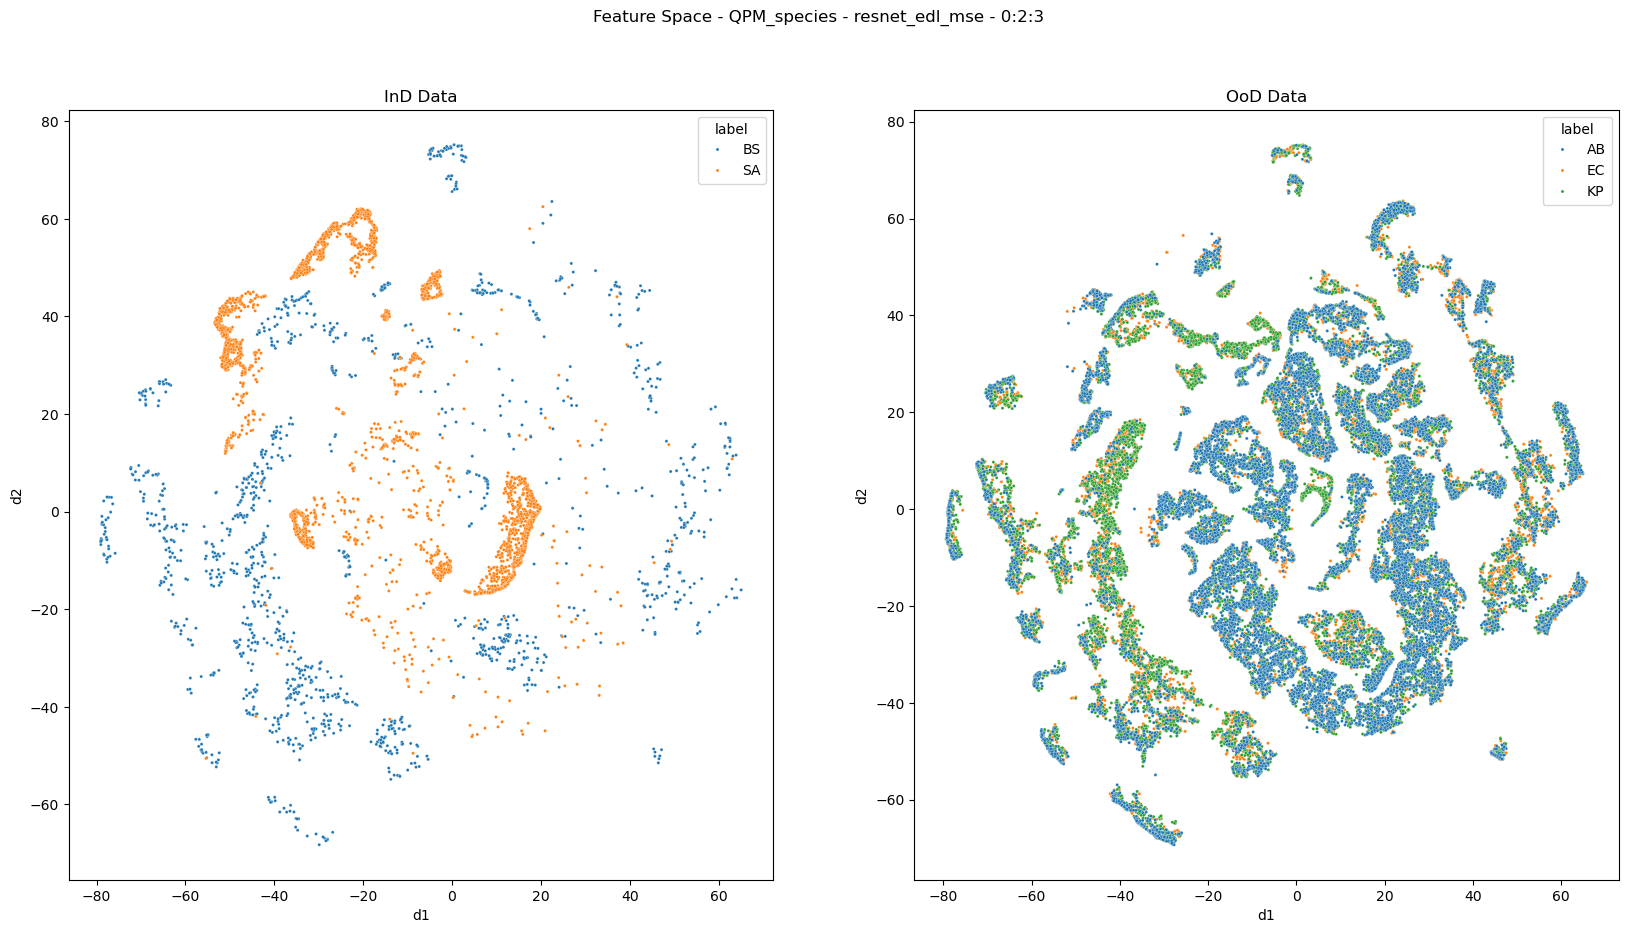

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

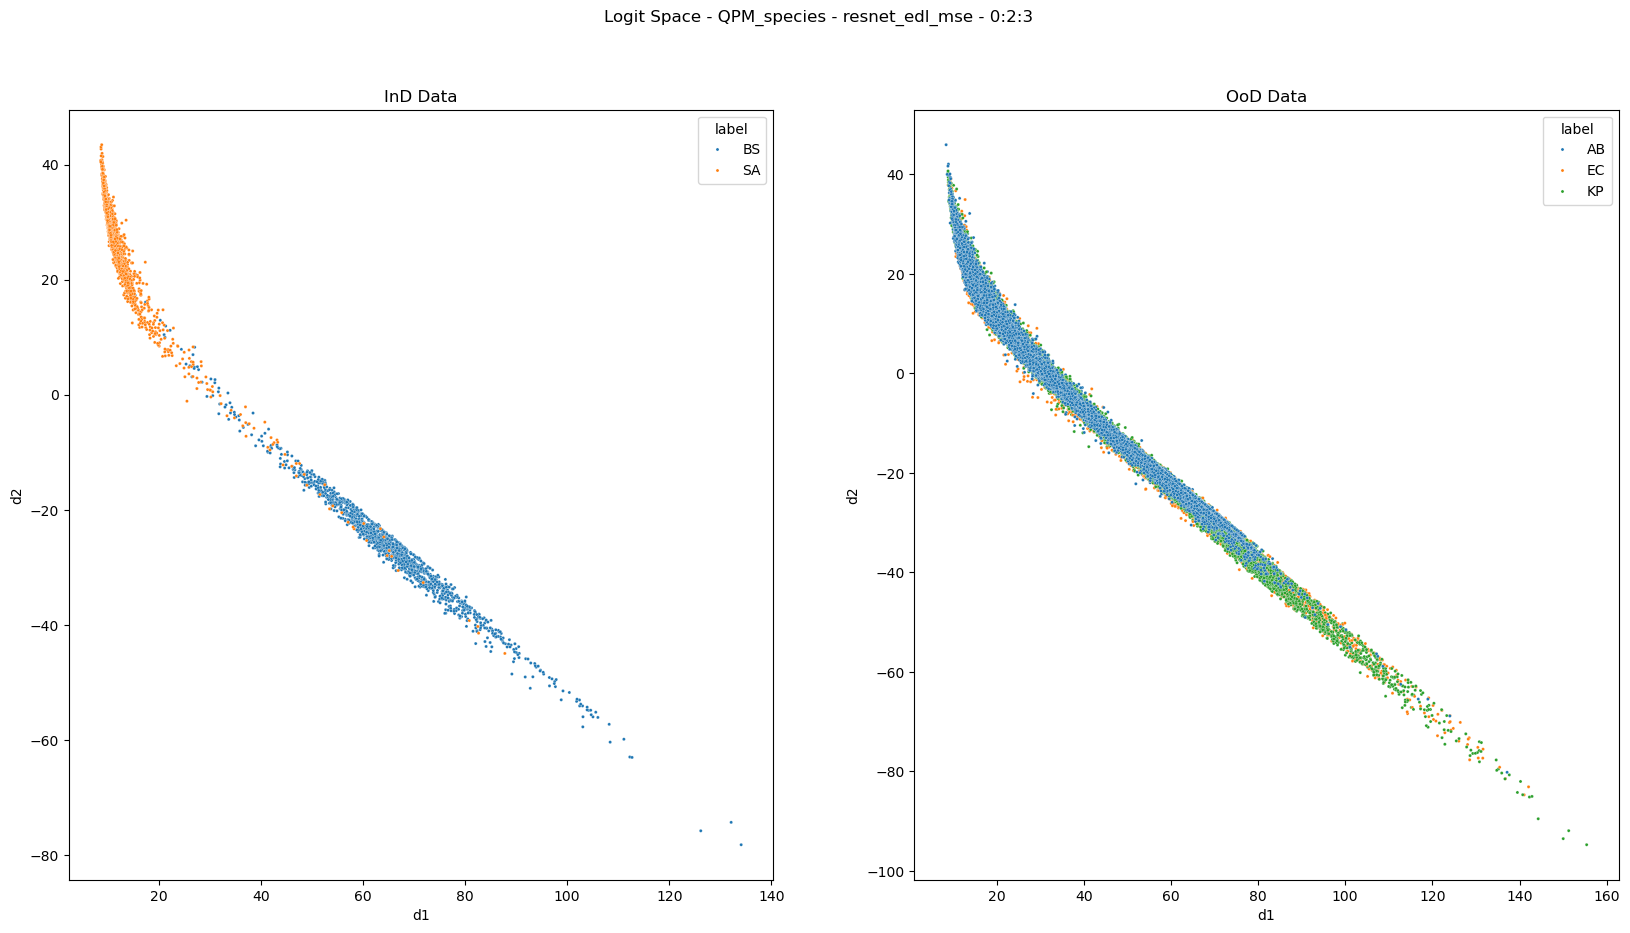

In [14]:
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:02<00:06,  2.13s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:04<00:04,  2.07s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:06<00:02,  2.09s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.17s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.14s/it]

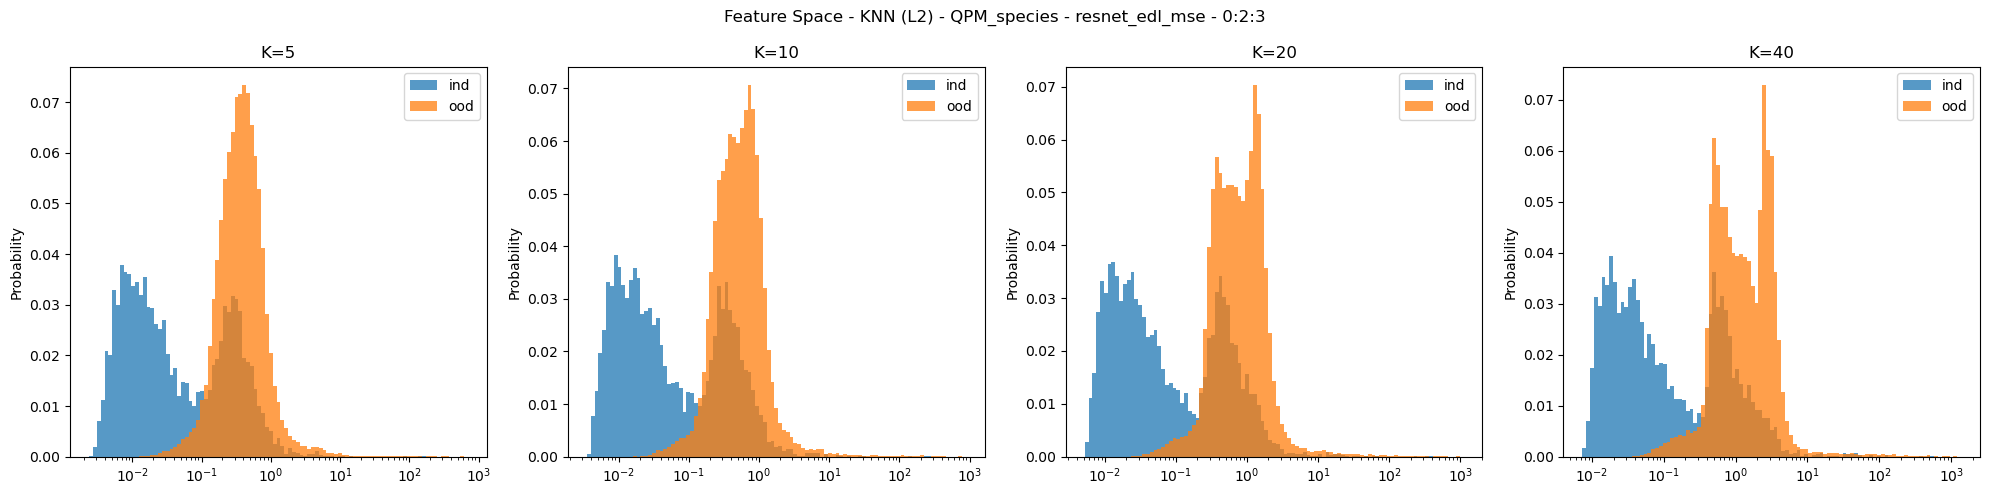

In [15]:
import faiss

index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:01<00:05,  1.92s/it]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:03<00:03,  1.92s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:06<00:02,  2.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.07s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.03s/it]

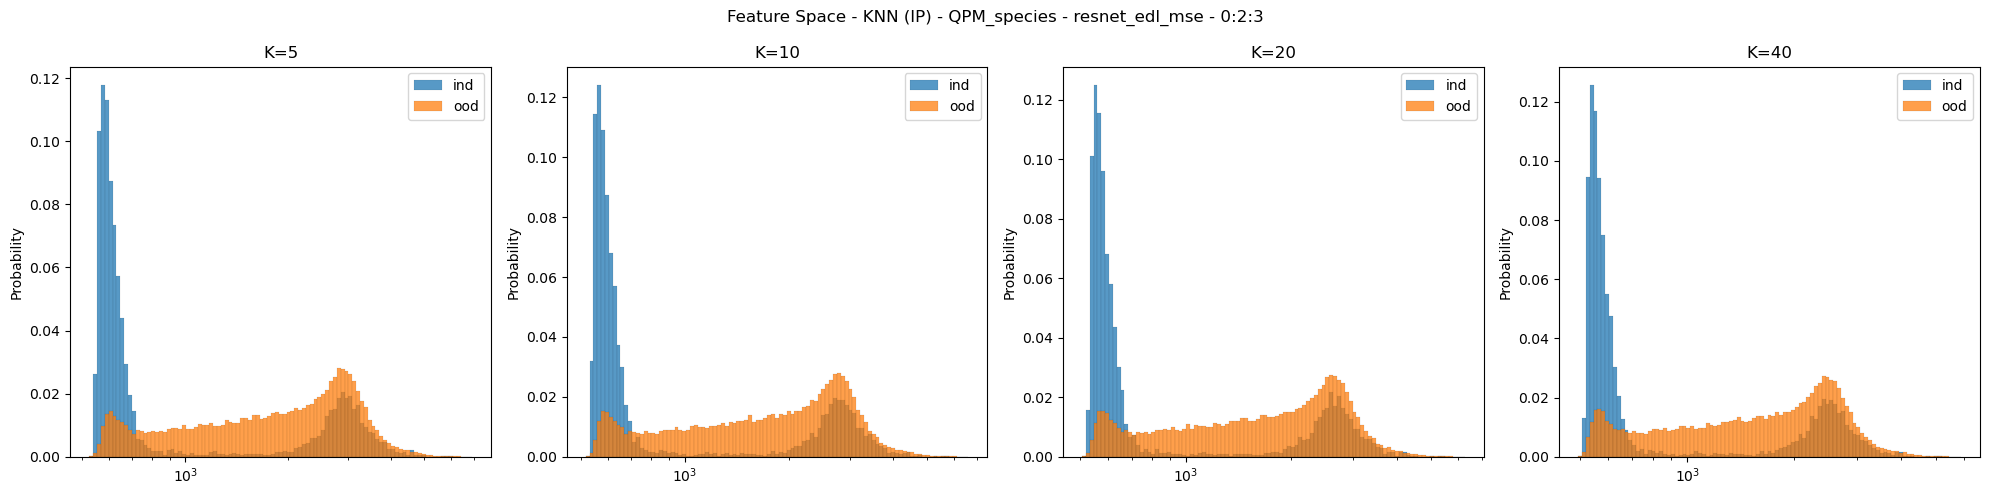

In [16]:
import faiss

index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:00<00:01,  2.50it/s]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:00<00:00,  2.38it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:01<00:00,  2.14it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]

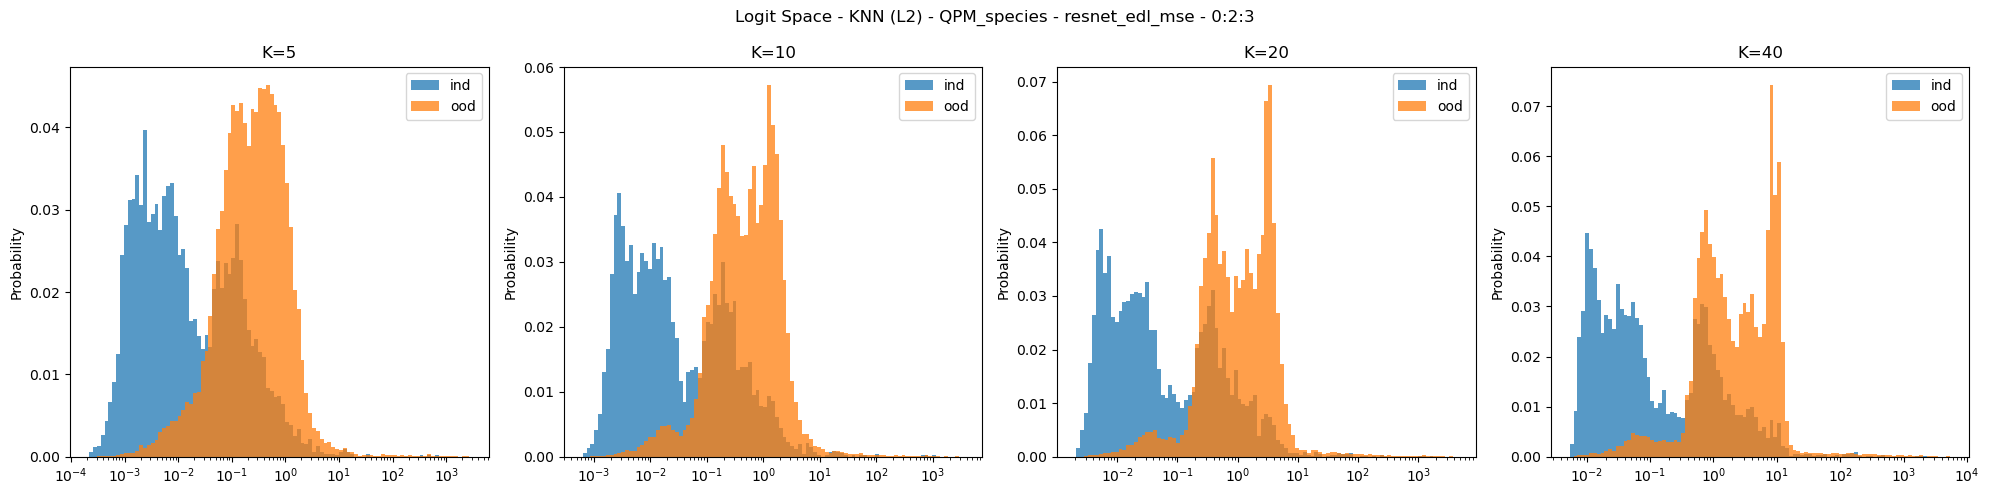

In [17]:
import faiss

index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████▎                                                                                    | 1/4 [00:00<00:01,  2.81it/s]

 50%|████████████████████████████████████████████████████████▌                                                        | 2/4 [00:00<00:00,  2.78it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▊                            | 3/4 [00:01<00:00,  2.57it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.14it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.31it/s]

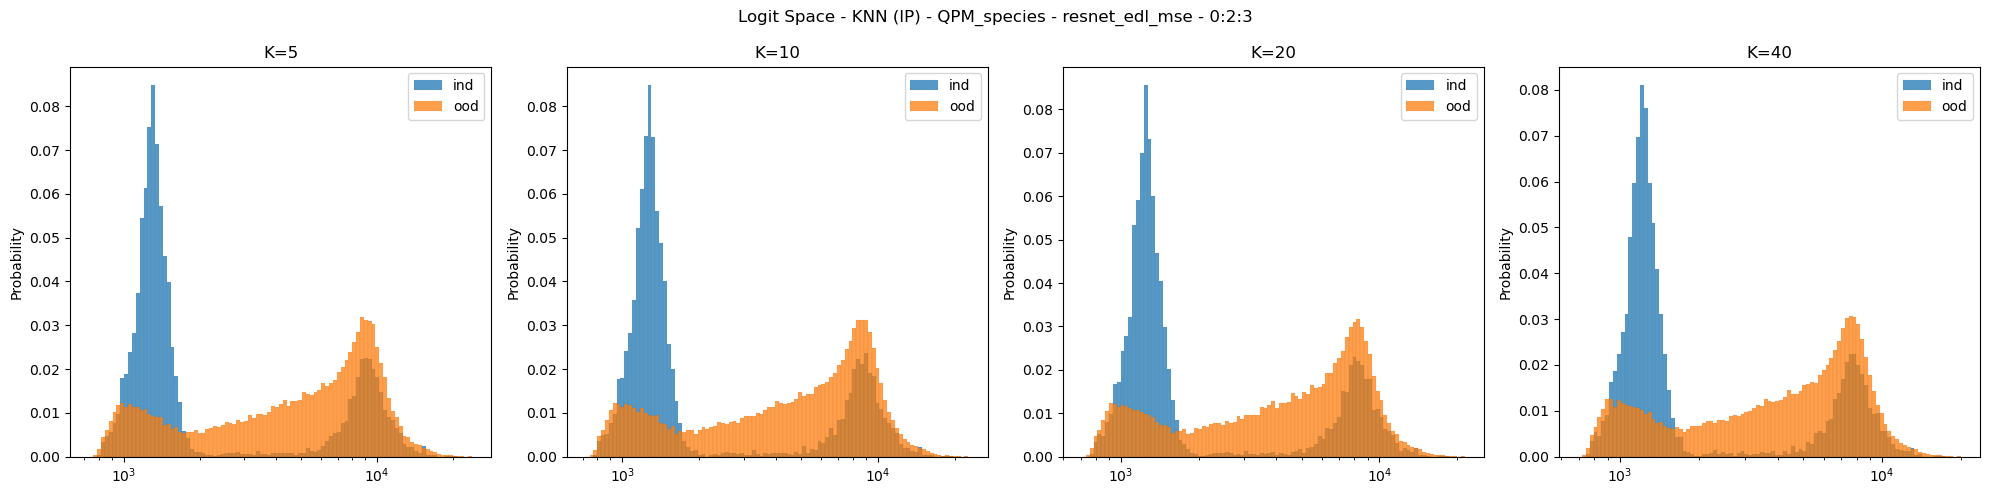

In [18]:
import faiss

index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_879908/3659132256.py:1: RuntimeWarning: overflow encountered in exp
  ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
/tmp/ipykernel_879908/3659132256.py:1: RuntimeWarning: invalid value encountered in divide
  ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
/tmp/ipykernel_879908/3659132256.py:6: RuntimeWarning: overflow encountered in exp
  ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
/tmp/ipykernel_879908/3659132256.py:6: RuntimeWarning: invalid value encountered in divide
  ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)


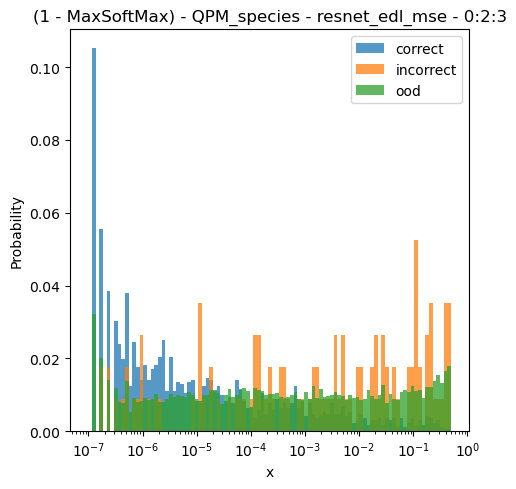

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

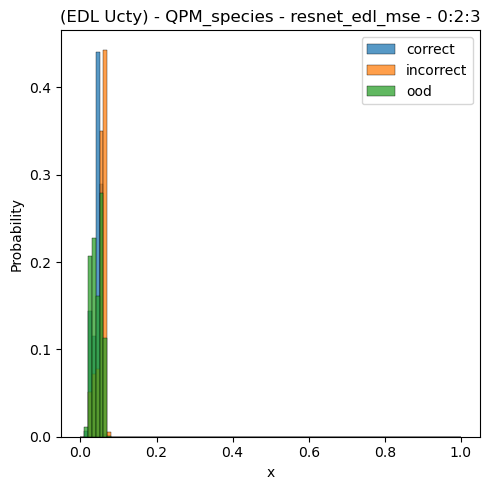

In [20]:
K = ind_lgt.shape[-1]
ind_belief = np.clip(ind_lgt, 0, None)
ind_pred = ind_lgt.argmax(-1)
ind_prob = ind_belief / (ind_belief.sum(-1, keepdims=True) + K)
ind_ucty = K / (ind_belief.sum(-1) + K)

if ood_str:
    ood_belief = np.clip(ood_lgt, 0, None)
    ood_pred = ood_lgt.argmax(-1)
    ood_prob = ood_belief / (ood_belief.sum(-1, keepdims=True) + K)
    ood_ucty = K / (ood_belief.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

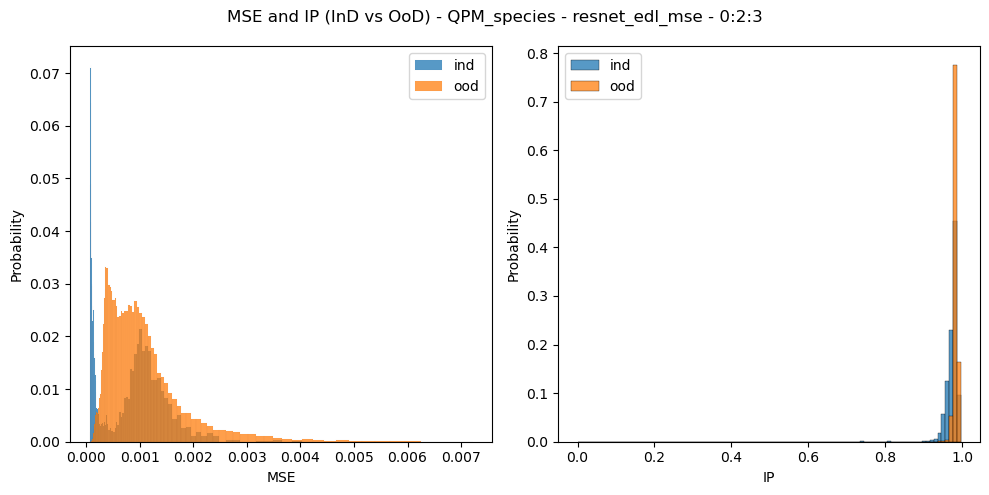

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()